# Notebook 3 — Evaluation & Visualization

Load the best model checkpoint and evaluate on the held-out test set.

**Outputs:** confusion matrix, classification report, training curves, sample predictions.

In [9]:
import os, sys, json, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# --- Project paths ---
NOTEBOOK_DIR  = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT  = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..', '..'))
TRANSFORMED   = os.path.join(NOTEBOOK_DIR, 'transformedDataset')
CHECKPOINT_DIR = os.path.join(NOTEBOOK_DIR, 'checkpoints')

sys.path.insert(0, os.path.abspath(NOTEBOOK_DIR))

from utils.dataset import MultimodalDataset
from utils.models import FusionModel
from utils.evaluation import (
    evaluate_model,
    print_classification_report,
    plot_confusion_matrix,
    plot_training_curves,
    CLASS_NAMES,
)

# --- Device ---
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: mps


## Step 1 — Load Best Model

In [10]:
model = FusionModel(num_classes=4, tab_input_dim=10, pretrained_image=False).to(DEVICE)

checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_fusion_model.pth')
state_dict = torch.load(checkpoint_path, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

print(f'Loaded checkpoint from: {checkpoint_path}')

Loaded checkpoint from: /Users/kiran/Downloads/fyp/Code/Fusion_Model/checkpoints/best_fusion_model.pth


## Step 2 — Prepare Test DataLoader

In [11]:
CBC_FEATURES = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT', 'MPV', 'RDW_CV']

# Need to re-apply the same StandardScaler derived from the training set
train_df = pd.read_csv(os.path.join(TRANSFORMED, 'train_split.csv'))
test_df  = pd.read_csv(os.path.join(TRANSFORMED, 'test_split.csv'))

# Fill NaN with training-set medians (same as Notebook 02)
for col in CBC_FEATURES:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

scaler = StandardScaler()
scaler.fit(train_df[CBC_FEATURES])
test_df[CBC_FEATURES] = scaler.transform(test_df[CBC_FEATURES])

test_dataset = MultimodalDataset(test_df, CBC_FEATURES, augment=False, project_root=PROJECT_ROOT)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f'Test samples: {len(test_dataset)}')

Test samples: 150


## Step 3 — Run Inference & Report Metrics

In [12]:
y_pred, y_true = evaluate_model(model, test_loader, DEVICE)
print_classification_report(y_true, y_pred, CLASS_NAMES)


Overall Accuracy: 0.8133

              precision    recall  f1-score   support

     Healthy       0.84      0.85      0.85        75
  Microcytic       0.82      0.82      0.82        61
  Normocytic       0.67      0.62      0.64        13
  Macrocytic       0.00      0.00      0.00         1

    accuracy                           0.81       150
   macro avg       0.58      0.57      0.58       150
weighted avg       0.81      0.81      0.81       150



## Step 4a — Confusion Matrix

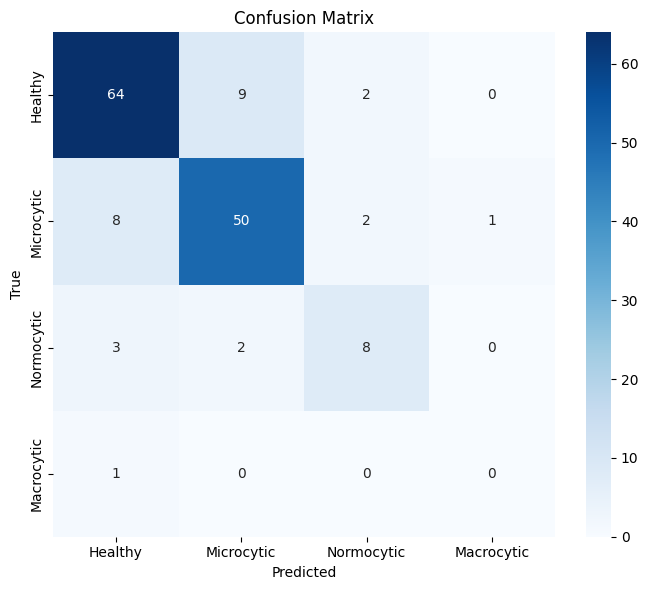

In [13]:
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

## Step 4b — Training / Validation Curves (both phases)

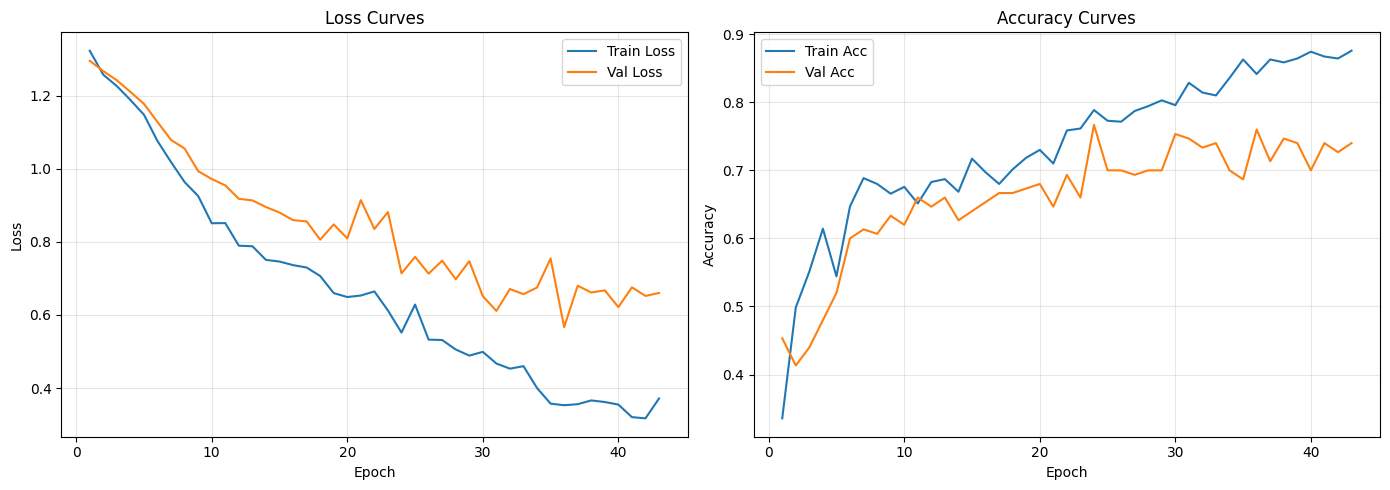

In [14]:
history_path = os.path.join(TRANSFORMED, 'training_history.json')
with open(history_path) as f:
    history = json.load(f)

plot_training_curves(history)

## Step 4c — Sample Correct & Incorrect Predictions

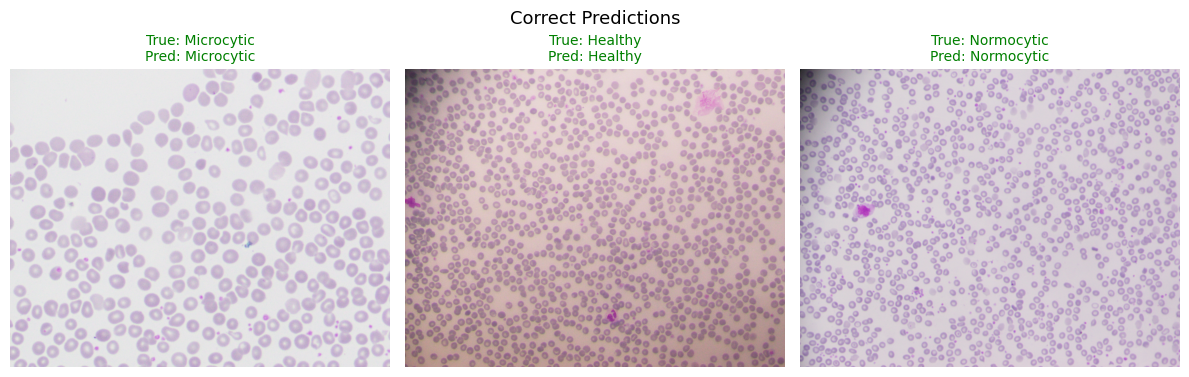

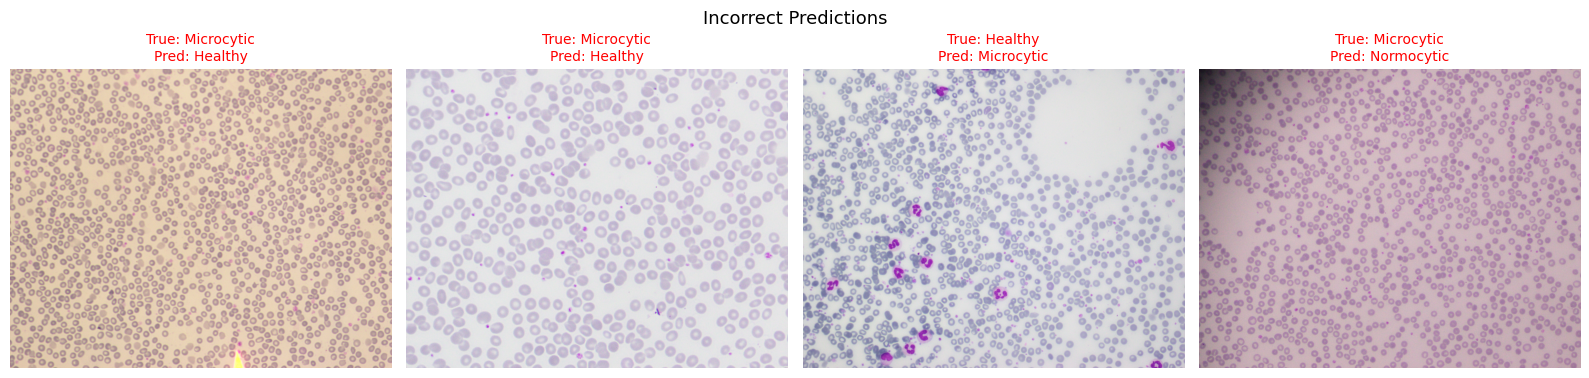

In [15]:
# Attach predictions back to test_df for visualization
test_vis = pd.read_csv(os.path.join(TRANSFORMED, 'test_split.csv'))  # un-scaled for display
test_vis['pred'] = y_pred
test_vis['correct'] = (test_vis['final_class'] == test_vis['pred'])

correct_samples   = test_vis[test_vis['correct']].groupby('final_class').head(1)
incorrect_samples = test_vis[~test_vis['correct']].head(4)

def show_predictions(samples_df, title_prefix):
    n = len(samples_df)
    if n == 0:
        print(f'No {title_prefix.lower()} predictions to show.')
        return
    fig, axes = plt.subplots(1, min(n, 4), figsize=(4 * min(n, 4), 4))
    if min(n, 4) == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, samples_df.iterrows()):
        img = Image.open(os.path.join(PROJECT_ROOT, row['image_path']))
        ax.imshow(img)
        true_name = CLASS_NAMES[int(row['final_class'])]
        pred_name = CLASS_NAMES[int(row['pred'])]
        color = 'green' if row['correct'] else 'red'
        ax.set_title(f'True: {true_name}\nPred: {pred_name}', color=color, fontsize=10)
        ax.axis('off')
    plt.suptitle(f'{title_prefix} Predictions', fontsize=13)
    plt.tight_layout()
    plt.show()

show_predictions(correct_samples, 'Correct')
show_predictions(incorrect_samples, 'Incorrect')

## Step 4d — Per-Class Analysis

     Class  Precision   Recall  F1-Score  Support
   Healthy   0.842105 0.853333  0.847682       75
Microcytic   0.819672 0.819672  0.819672       61
Normocytic   0.666667 0.615385  0.640000       13
Macrocytic   0.000000 0.000000  0.000000        1


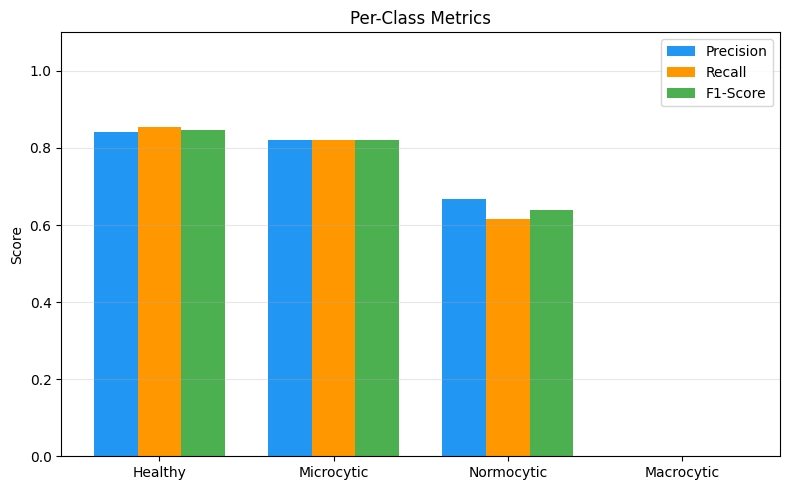

In [16]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2, 3], zero_division=0
)

per_class = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support.astype(int),
})
print(per_class.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(CLASS_NAMES))
width = 0.25
ax.bar(x - width, precision, width, label='Precision', color='#2196F3')
ax.bar(x,         recall,    width, label='Recall',    color='#FF9800')
ax.bar(x + width, f1,        width, label='F1-Score',  color='#4CAF50')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES)
ax.set_ylabel('Score')
ax.set_title('Per-Class Metrics')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

| Metric | Value |
|---|---|
| Overall Accuracy | *(see above)* |
| Macro F1 | *(see above)* |

**Expected:** Class 3 (Macrocytic, ~9 samples total) will likely have low recall due to extreme rarity.